# The drug problem in Europe

## Overdose deaths

Overdose deaths is a serious problem - perhaps one of the biggest problems regarding drug abuse. In this section we will try to figure out the patterns and analyze overdose deaths per country.

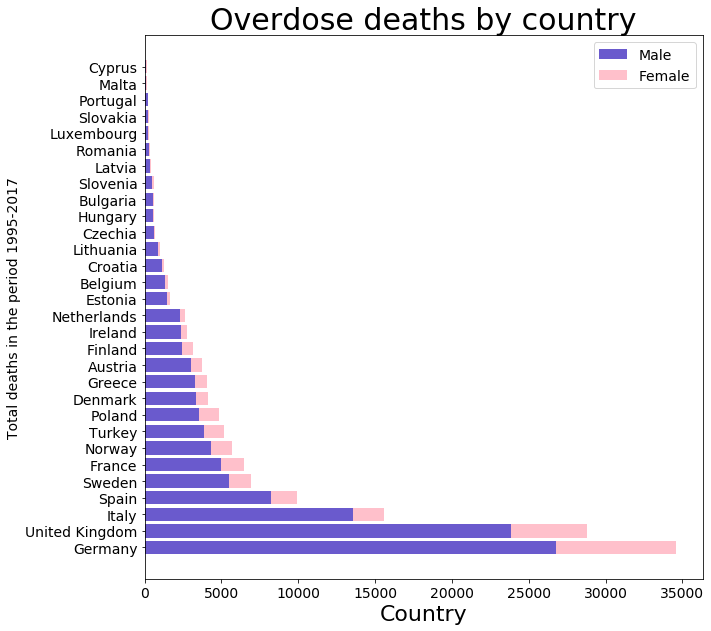

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import cartopy.io.shapereader as shpreader
from scipy.stats import t as student
from scipy.stats import beta

%matplotlib inline


plt.rcParams.update({'font.size': 14})
m = pandas.read_excel("./tables/drugDeaths/maleDeaths.xlsx")
m.fillna(0)
f = pandas.read_excel("./tables/drugDeaths/femaleDeaths.xlsx") 
f.fillna(0)
plt.figure(figsize=(10,10))

dataM = {}
dataF = {}
def replaceNan(data, indxs, val):
    for (i,v) in enumerate(indxs):
        if v == True:
            data[i] = val
for i,row in m.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].strip().replace("*", "").strip()
        dataM[country] = [row[col] for col in m.columns[:-1][1:]]
        nan_indx = np.isnan(dataM[country])
        replaceNan(dataM[country], nan_indx,0)
    
for i,row in f.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].strip().replace("*", "").strip()
        dataF[country] = [row[col] for col in f.columns[:-1][1:]]
        nan_indx = np.isnan(dataF[country])
        replaceNan(dataF[country], nan_indx,0)
        
sortedMaleKeys = sorted(dataM, key = lambda k: sum(dataM[k]), reverse=True)
maleY=[sum(dataM[k])  for k in sortedMaleKeys]
femaleY=[sum(dataF[k])  for k in sorted(dataF, key = lambda k: sum(dataF[k]), reverse = True)]




plt.barh(sortedMaleKeys, maleY, color="slateblue", label="Male")
plt.barh(sortedMaleKeys, femaleY, left = maleY ,color="pink", label="Female")

plt.title("Overdose deaths by country",fontsize=30)
plt.xlabel("Country",fontsize=22)
plt.ylabel("Total deaths in the period 1995-2017",fontsize=14)

pops = {
    
}
shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

pops = {
    
}

for c in countries:
    pops[c.attributes["NAME"]] = c.attributes["POP_EST"]
pops["Malta"] = 493000
data =[(sum(dataM[k])+ sum(dataF[k]))*10000/pops[k]  for k in sortedMaleKeys]

zscores = dict(zip(sortedMaleKeys,stats.zscore(data)))

stdDeaths = np.std(data)
meanDeaths = np.mean(data)
plt.legend()
plt.show()

C:\Users\DANIEL\Anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


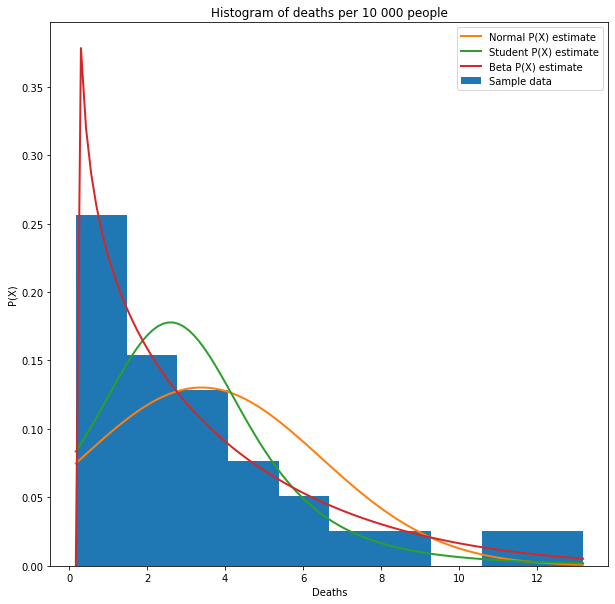

In [2]:
from scipy.stats import multivariate_normal as mvn 

sample=[x for x in data if x > 0]
xr = np.linspace(min(sample), max(sample), 100)    
n=len(sample)

mu = np.mean(sample)
sigma = (n-1)/n * np.var(sample)
P = [mvn.pdf(x, mu, sigma) for x in xr]

pars_stu = student.fit(sample)
P_stu = [student.pdf(x, *pars_stu) for x in xr ]

pars_beta = beta.fit(sample)
P_beta = [beta.pdf(x, *pars_beta) for x in xr ]
P_beta[0] =0 ##fixing a bug in beta.pdf - it returns a value of 600 on the first position

plt.figure(figsize=(10, 10))
plt.hist(sample,    label="Sample data", density=True)
plt.plot(xr, P,     label="Normal P(X) estimate", linewidth=2.0)
plt.plot(xr, P_stu,     label="Student P(X) estimate", linewidth=2.0)
plt.plot(xr, P_beta,     label="Beta P(X) estimate", linewidth=2.0)
plt.title("Histogram of deaths per 10 000 people")
plt.ylabel("P(X)")
plt.xlabel("Deaths")

plt.legend()

If we look at the histogram, we can see that the data about deaths per country is normally distributed(positively skewed) - with three outliers(we can see that they are Germany, the UK and Spain. So we can use the Z-score to calculate the p-value. I will use this information to plot a map. Colors will be going from green to red(red indicating high Z-score, green indicating low z-score).

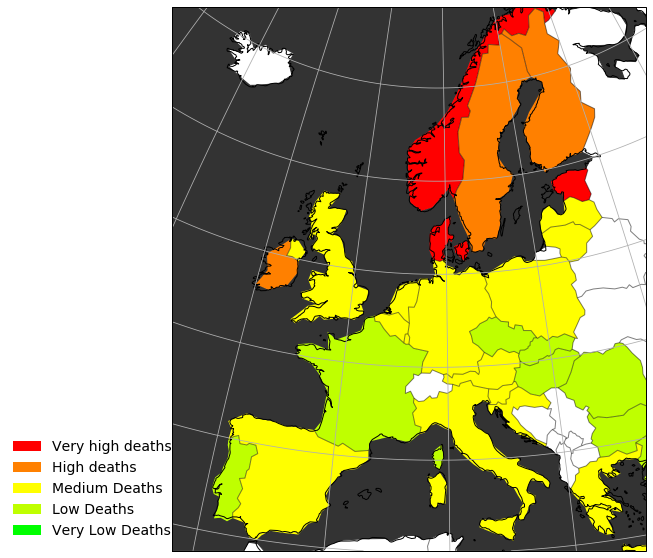

In [3]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
def getColor(zVal):
    bot10 = stats.norm.ppf(0.1)
    top10 = stats.norm.ppf(1-0.1)
    bot30 = stats.norm.ppf(0.25)
    top30 = stats.norm.ppf(1-0.25)

    if zVal > bot10 and zVal < top10:
        if zVal > bot30 and zVal < top30:
            return (1,1,0) ##yellow
        if zVal> bot30:
            return (1,0.5,0) ##orange
        return (0.75,1,0) ##lime
    if zVal> bot10:
        return (1,0,0) ##red
    return (0,1,0) ##green
    
    
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.EuroPP())

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    if country.attributes["NAME"] in sortedMaleKeys:
        ax.add_geometries([country.geometry], crs=ccrs.PlateCarree(), facecolor=getColor(zscores[country.attributes["NAME"]]))

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.OCEAN,facecolor=(0.2,0.2,0.2))
ax.gridlines()
values = ["Very high deaths", "High deaths", "Medium Deaths", "Low Deaths", "Very Low Deaths"]
rects = []

colors = [(1,0,0), (1,0.5,0), (1,1,0), (0.75,1,0), (0,1,0)]
for i in range(len(values)):
    rects.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i]))
    
ax.legend(rects, values,loc='lower right', bbox_to_anchor=(0.025, -0.0), fancybox=True, frameon=False, fontsize=14)  

leg = ax.get_legend()




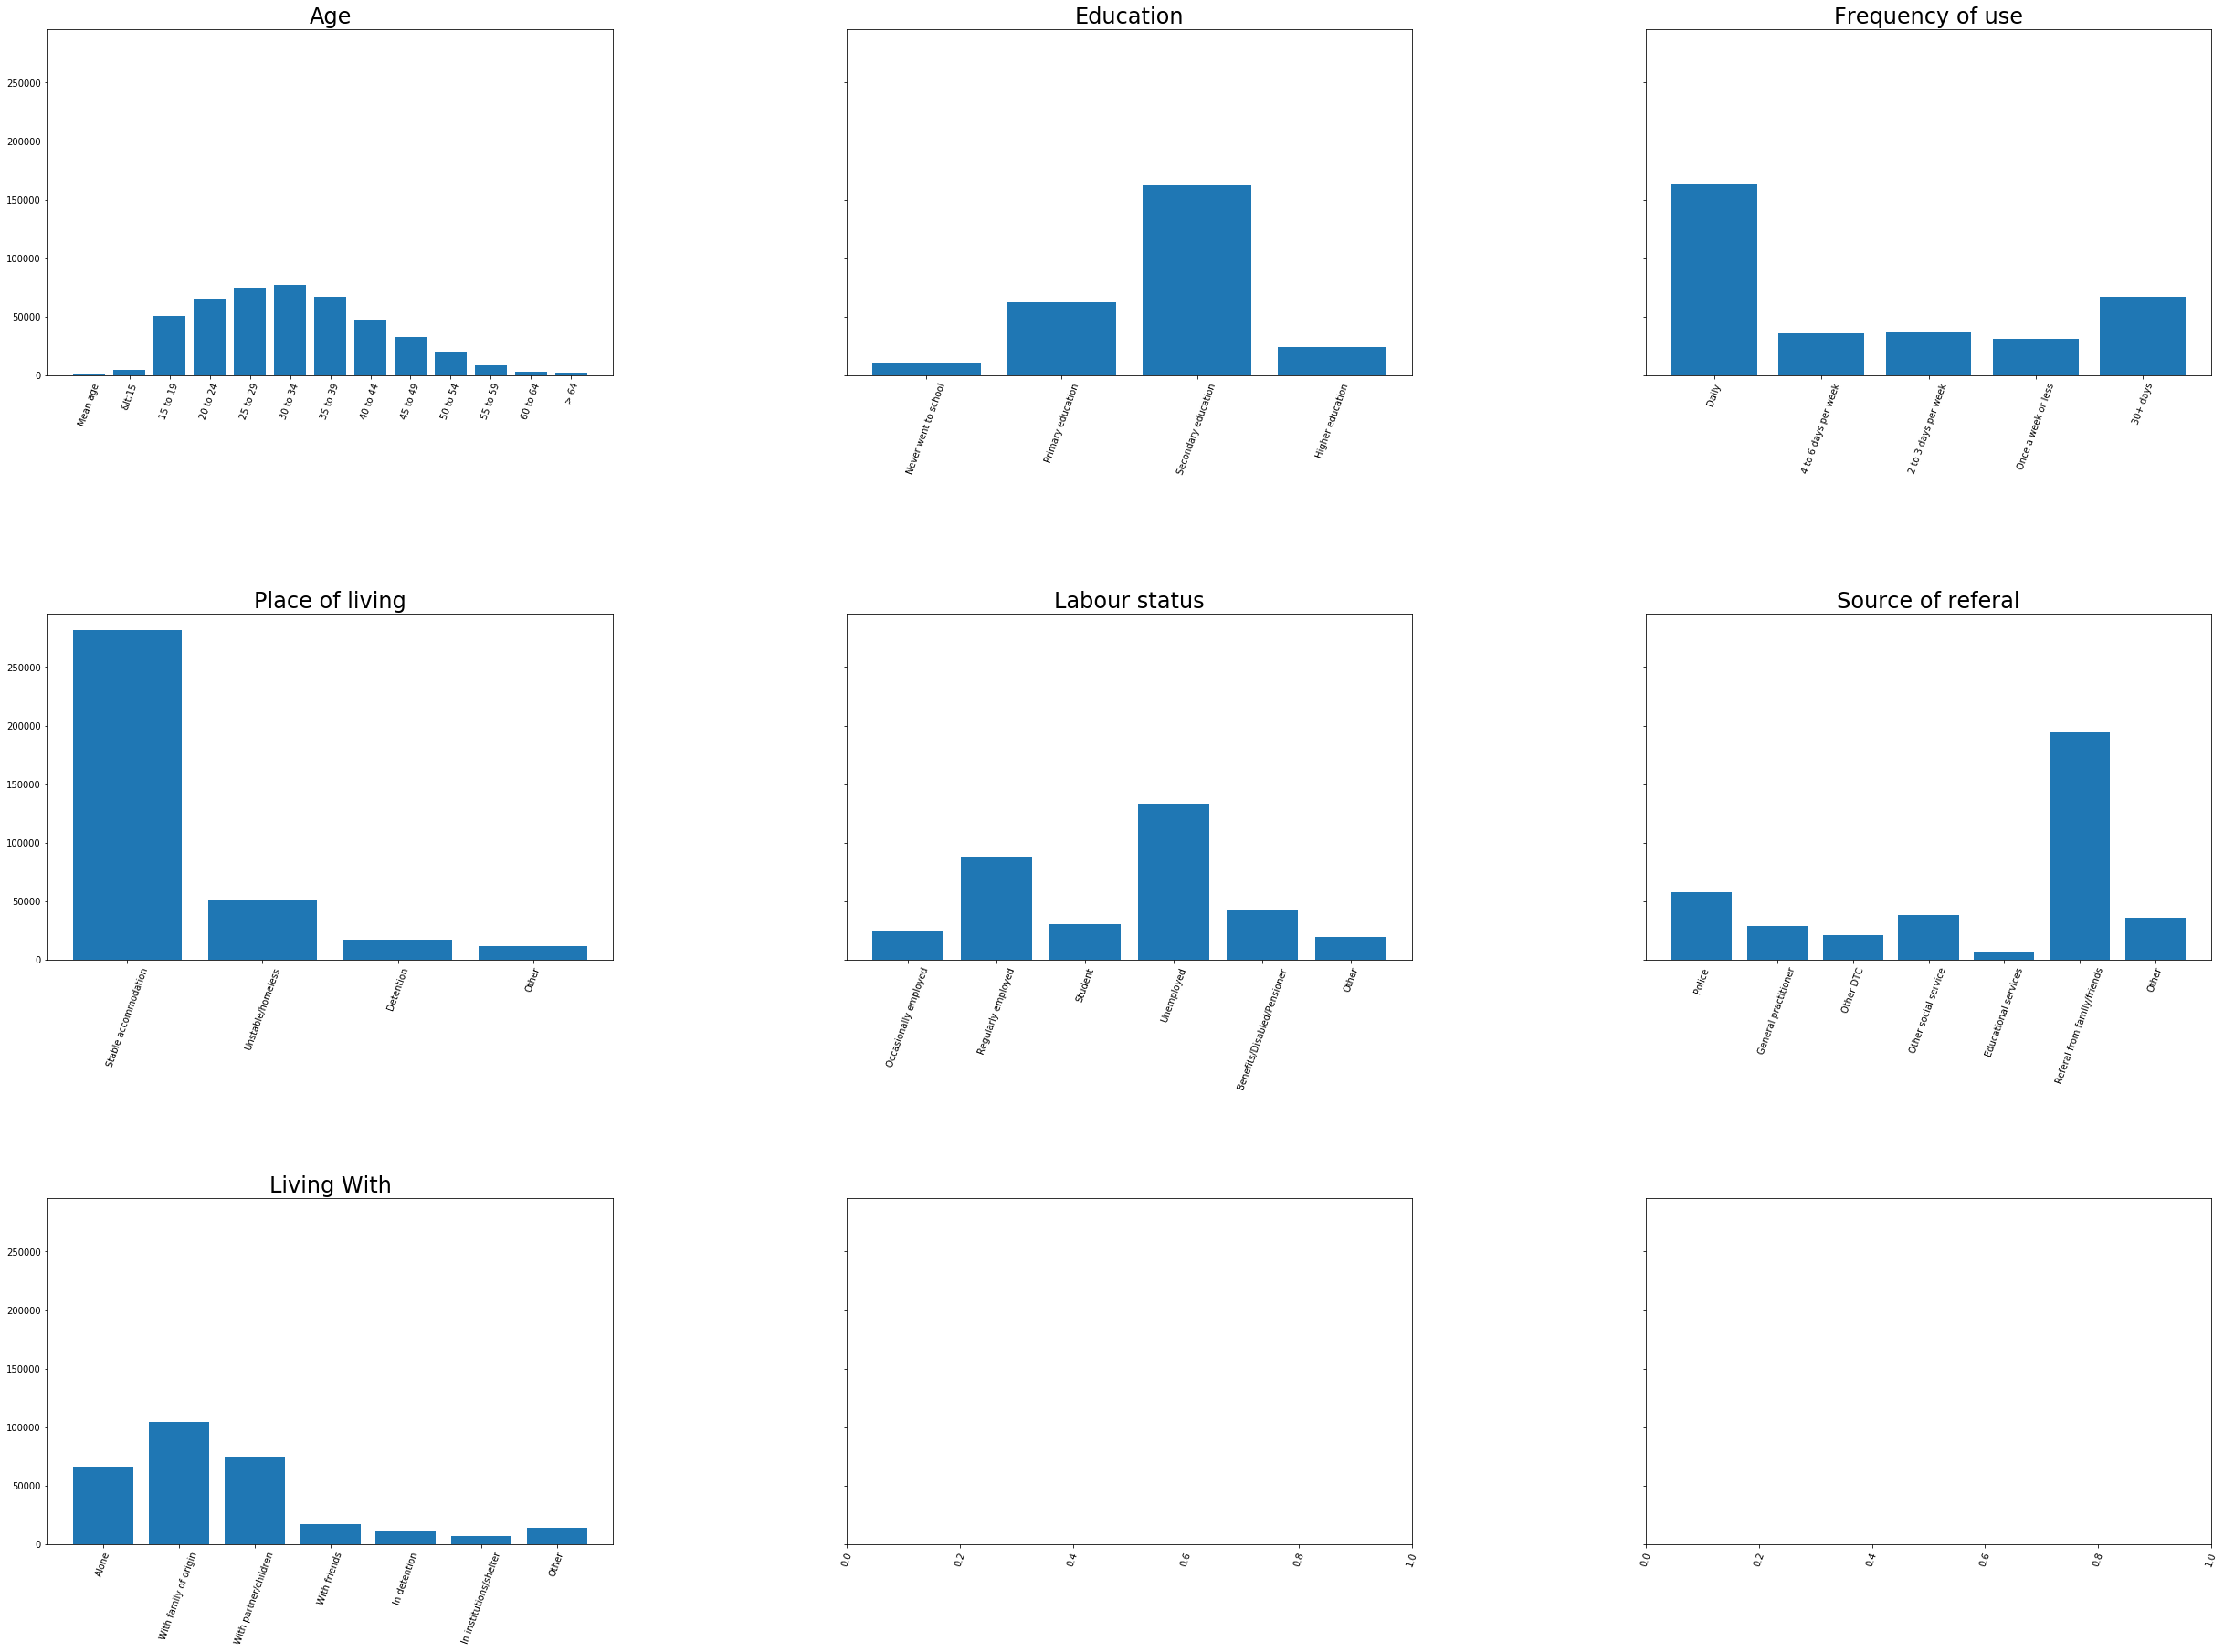

In [4]:
import math
tables = [{"file": "./tables/treatmentDemand/currentTrends/ageOfTreatment.xlsx", "title": "Age"}, 
          {"file":  "./tables/treatmentDemand/currentTrends/education.xlsx", "title": "Education"},
          {"file": "./tables/treatmentDemand/currentTrends/frequencyOfUse.xlsx", "title": "Frequency of use"},
          {"file": "./tables/treatmentDemand/currentTrends/livingWhere.xlsx", "title": "Place of living"},
          {"file": "./tables/treatmentDemand/currentTrends/labourStatus.xlsx", "title": "Labour status"},
          {"file": "./tables/treatmentDemand/currentTrends/sourceOfReferal.xlsx", "title": "Source of referal"},
          {"file": "./tables/treatmentDemand/currentTrends/livingWithWhom.xlsx", "title": "Living With"}]
fig, axs = plt.subplots(3, 3, figsize=(40, 30), sharey=True)
plt.rcParams.update({'font.size': 20})
fig.tight_layout(pad=12.0)

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=70)

for (num, tab) in enumerate(tables):
    currentTable = dict()
    
    file = pandas.read_excel(tab["file"])
    for i,row in file.iterrows():
        if type(row["Country"]) is str:
            for col in file.columns[:-3][2:]:
                if not col in currentTable and not np.isnan(row[col]):
                    currentTable[col] = row[col]
                elif not np.isnan(row[col]):
                    currentTable[col] += row[col]
    axs[math.floor(num/3)][num%3].bar(currentTable.keys(), currentTable.values())
    axs[math.floor(num/3)][num%3].set_title(tab["title"])
    



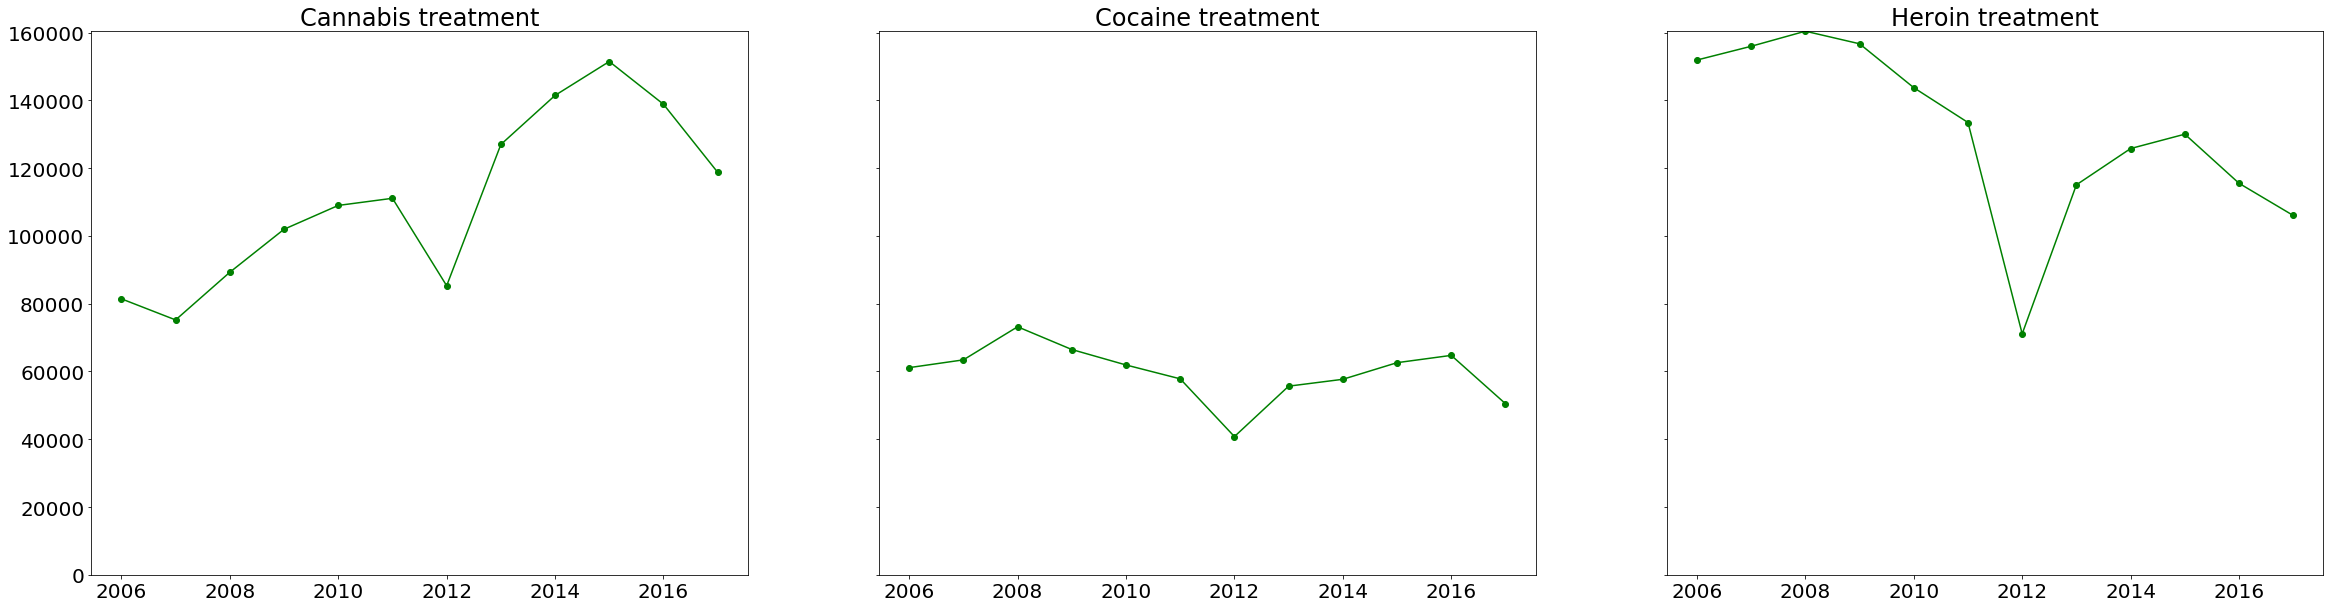

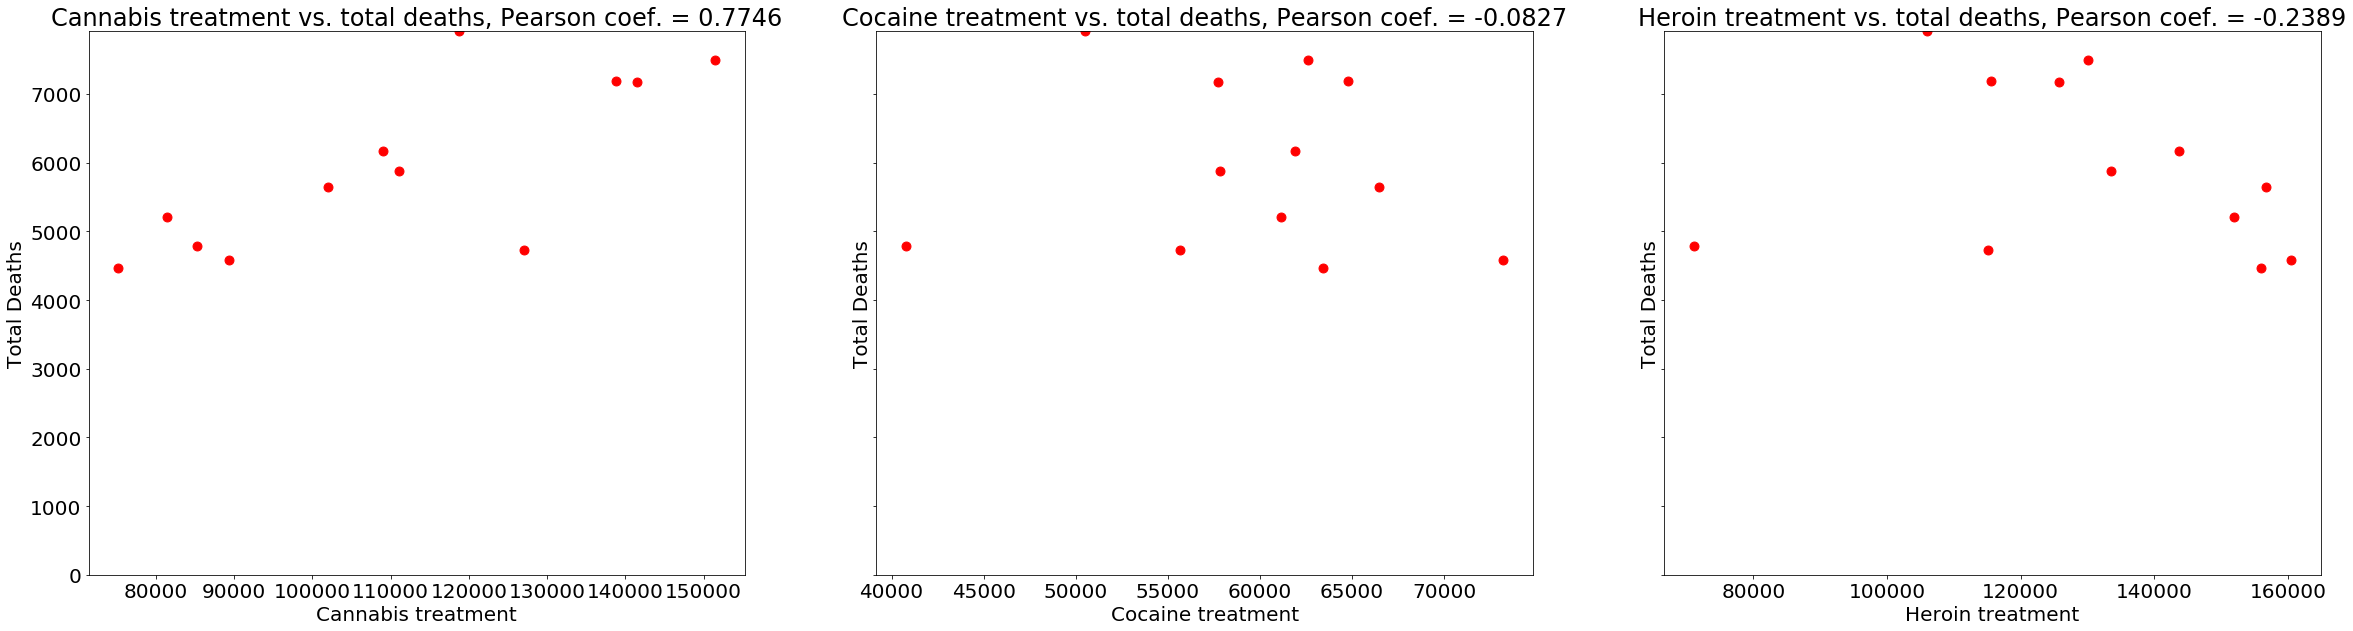

In [5]:
tables = [{"title":"Cannabis treatment", "path": "./tables/treatmentDemand/throughTheYears/cannabisTreatment.xlsx"}, 
         {"title":"Cocaine treatment", "path": "./tables/treatmentDemand/throughTheYears/cocaineTreatment.xlsx"},
         {"title":"Heroin treatment", "path": "./tables/treatmentDemand/throughTheYears/heroinTreatment.xlsx"}]
fig, axs = plt.subplots(1, 3, figsize=(40, 10), sharey=True)
fig1, axs1 = plt.subplots(1, 3, figsize=(40, 10), sharey=True)

deaths_by_year = []
for i in range(22):
    vy =0
    for country in dataM.keys():
        vy+= dataM[country][i] + dataF[country][i]
    deaths_by_year.append(vy)

cor_tables = []
for (num, tab) in enumerate(tables):
    currentTable = dict()
    file = pandas.read_excel(tab["path"])
    for i,row in file.iterrows():
        if type(row["Country"]) is str:
            for col in file.columns[1:][:-1]:
                if not col in currentTable and not np.isnan(row[col]):
                    currentTable[int(col)] = row[int(col)]
                elif not np.isnan(row[int(col)]):
                    currentTable[int(col)] += row[int(col)]
                    
    axs[num].set_ylim(0, max(currentTable.values()))
    axs[num].scatter(currentTable.keys(), currentTable.values(), color="green")
    axs[num].plot([float(k) for k in currentTable.keys()], [float(v) for v in currentTable.values()], color="green")
    
    dths = deaths_by_year[-len(currentTable.keys()):]
    
    axs1[num].set_ylim(0, max(dths))
    axs1[num].scatter(currentTable.values(),dths , color="red", s=80)
    
    axs[num].set_title(tab["title"])
    coef = np.corrcoef(x=np.array([float(v) for v in currentTable.values()]), y=np.array(dths))
    axs1[num].set_title(tab["title"] +" vs. total deaths, Pearson coef. = " + str(round(coef[0][1], 4)) )
    axs1[num].set_xlabel(tab["title"])
    axs1[num].set_ylabel("Total Deaths")
    

    

In [6]:
ost_table = dict()
file = pandas.read_excel("./tables/socialResponses/opioidSubstitutionTreatment.xlsx")

for i,row in file.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].strip().replace("*", "").strip()
        ost_table[country] = [row[col] for col in file.columns[:-1][2:]]
        nan_indx = np.isnan(ost_table[country])
        replaceNan(ost_table[country], nan_indx,0)
        ost_table[country] = np.sum(ost_table[country])*10000/pops[country]
       
zscores = dict(zip(ost_table.keys(),stats.zscore( [v for v in ost_table.values()] )  ))


In [7]:
def getColorOST(zVal):
    bot10 = stats.norm.ppf(0.1) ##Bottom border
    top10 = stats.norm.ppf(1-0.1) ## Top border
    
    bot30 = stats.norm.ppf(0.3)##These are mid range
    top30 = stats.norm.ppf(1-0.3) ##These are mid range
    
    if zVal > bot10 and zVal < top10:
        if zVal > bot30 and zVal < top30:
            return (1,1,0) ##yellow
        if zVal> bot30:
            return (0.75,1,0) ##lime
        return (1,0.5,0)  ##orange
    
    
    
    if zVal> bot10:
        return (0,1,0) ##green
    return (1,0,0) ##red

<Figure size 1080x720 with 0 Axes>

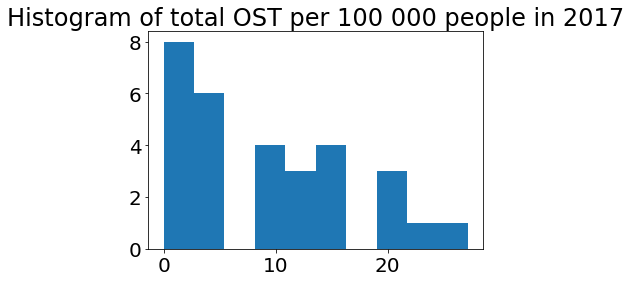

<Figure size 1080x720 with 0 Axes>

In [8]:
plt.hist(ost_table.values())
plt.title("Histogram of total OST per 100 000 people in 2017")
plt.figure(figsize=(15, 10))

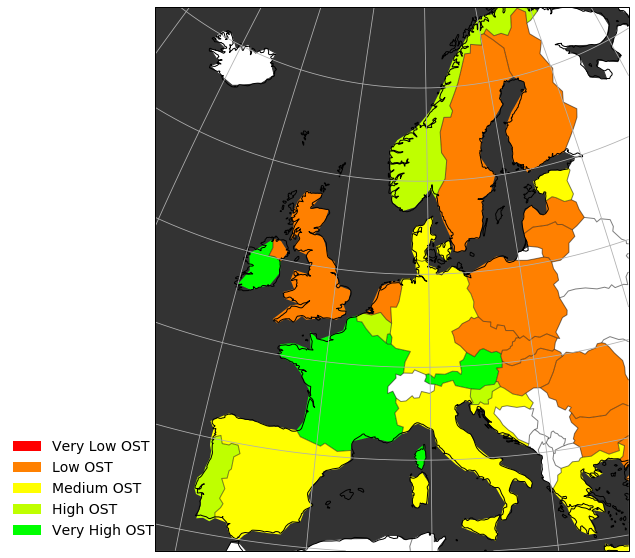

In [9]:
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.EuroPP())

shpfilename = shpreader.natural_earth(resolution='110m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
for country in countries:
    if country.attributes["NAME"] in ost_table.keys():
        ax.add_geometries([country.geometry], crs=ccrs.PlateCarree(), facecolor=getColorOST(zscores[country.attributes["NAME"]]))

ax.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=.5)
ax.coastlines(resolution='50m')
ax.add_feature(cartopy.feature.OCEAN,facecolor=(0.2,0.2,0.2))
ax.gridlines()
values = ["Very Low OST", "Low OST", "Medium OST", "High OST", "Very High OST"]
rects = []

colors = [(1,0,0), (1,0.5,0), (1,1,0), (0.75,1,0), (0,1,0)]
for i in range(len(values)):
    rects.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i]))
    
ax.legend(rects, values,loc='lower right', bbox_to_anchor=(0.025, -0.0), fancybox=True, frameon=False, fontsize=14)  

leg = ax.get_legend()

In [10]:
file = pandas.read_excel("./tables/socialResponses/opioidSubstitutionProviders.xlsx")
ost_supply = dict()
for i,row in file.iterrows():
    if type(row["Country"]) is str:
        country = row["Country"].strip().replace("*", "").strip()
        ost_supply[country] = dict()
    
        for col in file.columns[:-1][1:]:
            if str(row[col]) == "nan" or str(row[col]) == " ": ##not available
                ost_supply[country][col] = -1
            elif "Y" in str(row[col]): #available supply
                ost_supply[country][col] = 1
                continue
            elif "(i)" in str(row[col]): ##prision service
                ost_supply[country][col] = 2
            elif "(ii)" in str(row[col]): ##independent from pharma
                ost_supply[country][col] = 3
matrix = []
for c in ost_supply.keys():
    matrix.append([ost_supply[c][k] for k in ost_supply[c].keys()])

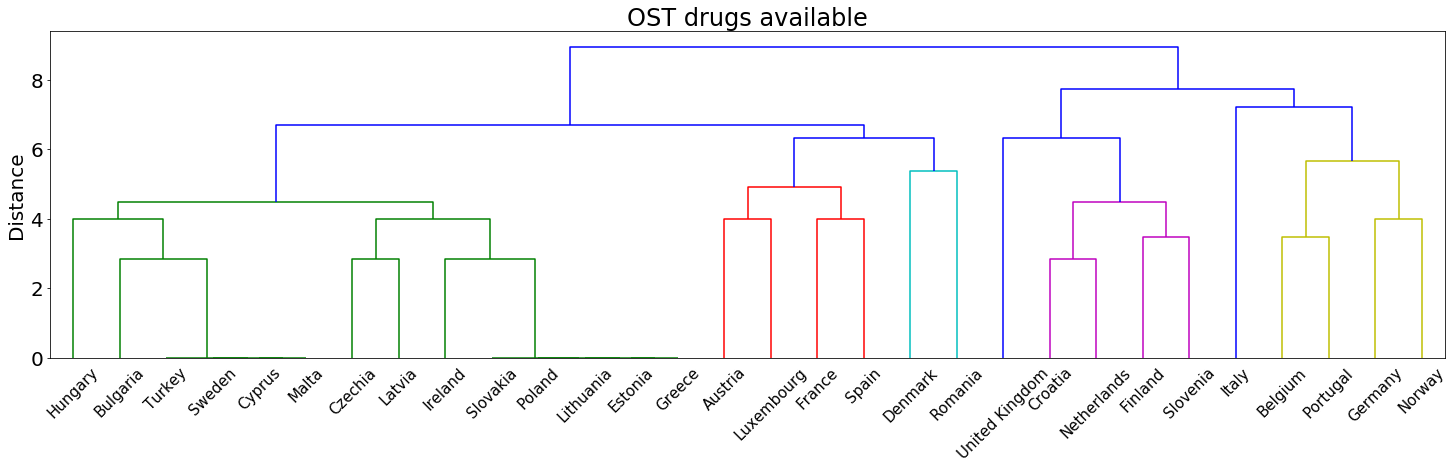

In [11]:
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
print()
L = sch.linkage(matrix, method="complete", metric="euclidean")

plt.figure(figsize=(25, 6))
labels = [c for c in ost_supply.keys()]
D    = sch.dendrogram(L, labels=labels, leaf_font_size=15)
plt.ylabel("Distance")
plt.title("OST drugs available")
plt.show()


In [12]:
import random
def ML(data):
    test = Orange.data.Table(data.domain, random.sample(data, 8))
    train = Orange.data.Table(data.domain, [d for d in data if d not in test])

    bayes = Orange.classification.NaiveBayesLearner()
    tree = Orange.classification.tree.TreeLearner(max_depth=2)
    knn3 = Orange.classification.knn.KNNLearner(n_neighbors=3)
    knn5 = Orange.classification.knn.KNNLearner(n_neighbors=5)
    knn7 = Orange.classification.knn.KNNLearner(n_neighbors=7)
    lr = Orange.classification.LogisticRegressionLearner(C=0.1)
    rf = Orange.classification.RandomForestLearner(n_estimators=100)
    st = Orange.classification.SimpleTreeLearner(max_depth=2)
    ml = Orange.classification.MajorityLearner()
    learners = [ knn3, knn5, knn7, tree, lr, bayes, rf, st, ml]
    classifiers = [learner(train) for learner in learners]
    
    

    print(" "*9 + " ".join("%-4s" % learner.name for learner in learners))
    print("neighbors " + " ".join(" %i  " % i for i in [3,5, 7]))
    cv = Orange.evaluation.CrossValidation(k=4)
    res = cv(data, learners)
    print("Accuracy %s" % " ".join("%.2f" % s for s in Orange.evaluation.CA(res)))
    print("AUC      %s" % " ".join("%.2f" % s for s in Orange.evaluation.AUC(res)))
    return [test, train]

In [13]:
## We need to create tables suitable for machine learning
import Orange
attributes = ["mtdn-treatment-centre",
              "mtdn-spec-medical-doctor",
              "mtdn-any-medical-doctor",
              "mtdn-pharma",
              "mtdn-mobile",
              "mtdn-other",
              "bur-treatment-centre",
              "bur-spec-medical-doctor",
              "bur-any-medical-doctor",
              "bur-pharma",
              "bur-mobile",
              "bur-other",
              "bur-nal-treatment-centre",
              "bur-nal-spec-medical-doctor",
              "bur-nal-any-medical-doctor",
              "bur-nal-pharma",
              "bur-nal-mobile",
              "bur-nal-other",
              "morph-treatment-centre",
              "morph-spec-medical-doctor",
              "morph-any-medical-doctor",
              "morph-pharma",
              "morph-mobile",
              "morph-other"]
variables = [ Orange.data.DiscreteVariable(a, ["no", "yes"]) for a in attributes]
ost = Orange.data.DiscreteVariable("ost", ["Very Low OST", "Low OST", "Medium OST", "High OST", "Very High OST"])

domain = Orange.data.Domain(variables, ost)
X = []
Y=[]
for c in ost_supply.keys():
    insertion = []
    
    for col in ost_supply[c].keys():
        if ost_supply[c][col] == -1:
            insertion.append(0)
        ##elif ost_supply[c][col] == 1:
        ##    insertion.append(1)
        ##elif ost_supply[c][col] == 2:
        ##    insertion.append(2)
        ##elif ost_supply[c][col] == 3:
        ##    insertion.append(3)
        else:
            insertion.append(1)
    X.append(insertion)
    Y.append(colors.index(getColorOST(zscores[c])))
X = np.array(X)

Y = np.array(Y)
data = Orange.data.Table(domain, X, Y)


In [14]:
tst, lrn = ML(data)
learner = Orange.classification.CN2Learner()
classifier = learner(data)

classifier = learner(data)
for rule in classifier.rule_list:
    p = rule.prediction
    l = rule.curr_class_dist.tolist()
    conf = l[p]/sum(l)
    if(conf > 0.6) and sum(l) > 3:
        print(str(rule) + " Confidence of " + str(round(conf,2)))

         knn  knn  knn  tree logistic regression naive bayes random forest simple tree majority
neighbors  3    5    7  
Accuracy 0.40 0.57 0.53 0.40 0.60 0.47 0.40 0.47 0.47
AUC      0.53 0.55 0.58 0.48 0.64 0.66 0.60 0.53 0.45
IF mtdn-treatment-centre==no THEN ost=Low OST  Confidence of 0.75


In [15]:
## We need to create tables suitable for machine learning
import Orange
attributes = ["mtdn",
              "mtdn-alt",
              "bur",
              "bur-alt",
              "bur-nal",
              "bur-nal-alt",
              "morph",
              "morph-alt"]
variables = [ Orange.data.DiscreteVariable(a, ["no", "yes"]) for a in attributes]
ost = Orange.data.DiscreteVariable("ost", ["Very Low OST", "Low OST", "Medium OST", "High OST", "Very High OST"])

domain = Orange.data.Domain(variables, ost)
X = []
Y=[]
for c in ost_supply.keys():
    insertion = []
    for i in range(0,4):
        
        for k in range(0,2):
            ost_ck = []
            for j in range(0,3):
                key = list(ost_supply[c].keys())[i*6 + k*3 + j]
                if ost_supply[c][key] == -1:
                    ost_ck.append(0)
                else:
                    ost_ck.append(1)
            if sum(ost_ck) == 0:
                insertion.append(0)
            else:
                insertion.append(1)
    X.append(insertion)
    Y.append(colors.index(getColorOST(zscores[c])))
    

X = np.array(X)    
Y = np.array(Y)
print(Y)
data = Orange.data.Table(domain, X, Y)
tst1,lrn1 = ML(data)
learner = Orange.classification.CN2Learner()
classifier = learner(data)

d = {0: "Low", 1: "Medium", 2: "High"}
learner = Orange.classification.CN2Learner()
classifier = learner(data)

classifier = learner(data)
for rule in classifier.rule_list:
    p = rule.prediction
    l = rule.curr_class_dist.tolist()
    conf = l[p]/sum(l)
    if(conf > 0.6) and sum(l) >= 3:
        print(str(rule) + " Confidence of " + str(round(conf,2)))

[4 3 1 2 1 1 2 2 1 4 2 2 1 4 2 1 1 4 4 1 3 1 3 1 1 3 2 1 1 1]
         knn  knn  knn  tree logistic regression naive bayes random forest simple tree majority
neighbors  3    5    7  
Accuracy 0.53 0.47 0.47 0.40 0.47 0.43 0.47 0.40 0.47
AUC      0.61 0.59 0.52 0.52 0.58 0.57 0.55 0.52 0.45
IF mtdn-alt==no AND bur-nal-alt!=no THEN ost=Low OST  Confidence of 1.0
IF mtdn==no THEN ost=Low OST  Confidence of 0.75
IF bur-alt!=no AND morph!=yes THEN ost=High OST  Confidence of 0.75


In [16]:
def getColorOST(a):
    
    p20 = stats.norm.ppf(0.1) ##These are mid range
    p80 = stats.norm.ppf(0.9) ##These are mid range
    if a > p20:
        if a < p80:
            return (1,1,0)
        return (1,0.5,0)
    return (0.75,1,0)

In [17]:
## We need to create tables suitable for machine learning
import Orange
attributes = ["mtdn-treatment-centre",
              "mtdn-spec-medical-doctor",
              "mtdn-any-medical-doctor",
              "mtdn-pharma",
              "mtdn-mobile",
              "mtdn-other",
              "bur-treatment-centre",
              "bur-spec-medical-doctor",
              "bur-any-medical-doctor",
              "bur-pharma",
              "bur-mobile",
              "bur-other",
              "bur-nal-treatment-centre",
              "bur-nal-spec-medical-doctor",
              "bur-nal-any-medical-doctor",
              "bur-nal-pharma",
              "bur-nal-mobile",
              "bur-nal-other",
              "morph-treatment-centre",
              "morph-spec-medical-doctor",
              "morph-any-medical-doctor",
              "morph-pharma",
              "morph-mobile",
              "morph-other"]
variables = [ Orange.data.DiscreteVariable(a, ["no", "yes"]) for a in attributes]
ost = Orange.data.DiscreteVariable("ost", ["Low", "Medium", "High"])

domain = Orange.data.Domain(variables, ost)
X = []
Y=[]
for c in ost_supply.keys():
    insertion = []
    
    for col in ost_supply[c].keys():
        if ost_supply[c][col] == -1:
            insertion.append(0)
        else:
            insertion.append(1)
    X.append(insertion)
    col = colors.index(getColorOST(zscores[c]))
    if col == 1:
        Y.append(0)
    elif col ==2:
        Y.append(1)
    elif col ==3:
        Y.append(2)
        
X = np.array(X)    
Y = np.array(Y)
data = Orange.data.Table(domain, X, Y)

tst2, lrn2 = ML(data)

tree = Orange.classification.tree.TreeLearner(max_depth=2)
trlrn = tree(lrn2)

from sklearn import tree


         knn  knn  knn  tree logistic regression naive bayes random forest simple tree majority
neighbors  3    5    7  
Accuracy 0.87 0.90 0.87 0.73 0.83 0.57 0.90 0.80 0.83
AUC      0.71 0.65 0.59 0.38 0.72 0.75 0.74 0.64 0.44


In [18]:
learner = Orange.classification.CN2Learner()
classifier = learner(data)

classifier = learner(data)
for rule in classifier.rule_list:
    p = rule.prediction
    l = rule.curr_class_dist.tolist()
    conf = l[p]/sum(l)
    if(conf >= 0.66) and sum(l) >= 5:
        print(str(rule) + " Confidence of " + str(round(conf,2)))

IF mtdn-any-medical-doctor!=no THEN ost=Medium  Confidence of 1.0
IF mtdn-treatment-centre!=no THEN ost=Medium  Confidence of 1.0
IF TRUE THEN ost=Medium  Confidence of 0.83


In [19]:
## We need to create tables suitable for machine learning
import Orange
attributes = ["mtdn",
              "mtdn-alt",
              "bur",
              "bur-alt",
              "bur-nal",
              "bur-nal-alt",
              "morph",
              "morph-alt"]
variables = [ Orange.data.DiscreteVariable(a, ["no", "yes"]) for a in attributes]
ost = Orange.data.DiscreteVariable("ost", ["Low", "Medium", "High"])

domain = Orange.data.Domain(variables, ost)
X = []
Y=[]
for c in ost_supply.keys():
    insertion = []
    for i in range(0,4):
        
        for k in range(0,2):
            ost_ck = []
            for j in range(0,3):
                key = list(ost_supply[c].keys())[i*6 + k*3 + j]
                if ost_supply[c][key] == -1:
                    ost_ck.append(0)
                else:
                    ost_ck.append(1)
            if sum(ost_ck) == 0:
                insertion.append(0)
            else:
                insertion.append(1)
    X.append(insertion)
    col = colors.index(getColorOST(zscores[c]))
    if col == 1:
        Y.append(0)
    elif col ==2:
        Y.append(1)
    elif col ==3:
        Y.append(2)
    

X = np.array(X)    
Y = np.array(Y)

data = Orange.data.Table(domain, X, Y)
tst3, lrn3 = ML(data)

         knn  knn  knn  tree logistic regression naive bayes random forest simple tree majority
neighbors  3    5    7  
Accuracy 0.90 0.83 0.83 0.87 0.83 0.73 0.90 0.83 0.83
AUC      0.63 0.66 0.59 0.56 0.71 0.69 0.64 0.54 0.44


In [20]:
learner = Orange.classification.CN2Learner()
classifier = learner(data)

classifier = learner(data)
for rule in classifier.rule_list:
    p = rule.prediction
    l = rule.curr_class_dist.tolist()
    conf = l[p]/sum(l)
    if(conf >= 0.66) and sum(l) >= 5:
        print(str(rule) + " Confidence of " + str(round(conf,2)))

IF mtdn-alt==no AND mtdn!=no THEN ost=Medium  Confidence of 1.0
IF bur-nal-alt!=no AND morph!=yes THEN ost=Medium  Confidence of 1.0
IF TRUE THEN ost=Medium  Confidence of 0.83


In [21]:
def regressor(data):
    lin = Orange.regression.linear.LinearRegressionLearner()
    lin.name = "lin"
    rf = Orange.regression.random_forest.RandomForestRegressionLearner()
    rf.name = "rf"
    ridge = Orange.regression.RidgeRegressionLearner()
    ridge.name = "ridge"
    mean = Orange.regression.MeanLearner()

    learners = [lin, rf, ridge, mean]
    
    
    print(" "*9 + " ".join("%-4s" % learner.name for learner in learners))
    cv = Orange.evaluation.CrossValidation(k=5)
    res = cv(data, learners)
    print("R2       %s" % " ".join("%.2f" % s for s in Orange.evaluation.R2(res)))
    print("MAE      %s" % " ".join("%.2f" % s for s in Orange.evaluation.MAE(res)))
    return res

         lin  rf   ridge mean
R2       0.83 0.87 0.83 -0.00
MAE      90.40 59.32 90.40 183.62


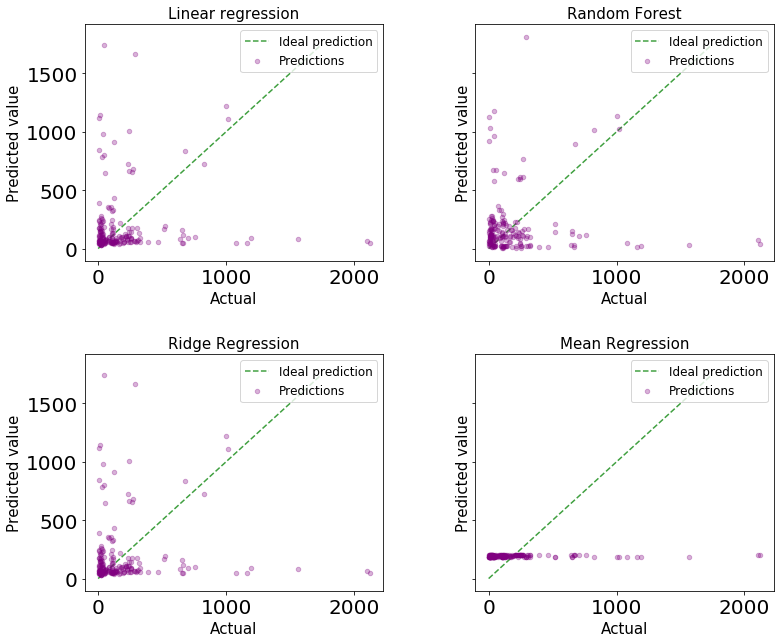

In [22]:
tables = [{ "path": "./tables/treatmentDemand/throughTheYears/cannabisTreatment.xlsx"}, 
         { "path": "./tables/treatmentDemand/throughTheYears/cocaineTreatment.xlsx"},
         { "path": "./tables/treatmentDemand/throughTheYears/heroinTreatment.xlsx"}]

deaths_by_year = {}
years = [1995 + i for i in range(23)]
for i in range(23):
    for country in dataM.keys():
        if country not in deaths_by_year:
            deaths_by_year[country] = dict()
        deaths_by_year[country][1995 + i]= dataM[country][i] + dataF[country][i]

matrix = [] 

years = set()
for (num, tab) in enumerate(tables):
    file = pandas.read_excel(tab["path"])
    drug = {}
    for i,row in file.iterrows():
        r = []
        if type(row["Country"]) is str:
            for col in file.columns[1:][:-1]:
                try:
                    r.append(int(row[col]))
                except:
                    r.append(0)
            drug[row["Country"].strip().replace("*", "").strip()] = r
    matrix.append(drug)

main_matrix = []
death_matrix=[]
for c in matrix[0].keys():
    cmatrix = []
    cana = matrix[0]
    coc = matrix[1]
    hero = matrix[2]
    
    for i in range(11):
        deaths = deaths_by_year[c][2007+i]
        he=hero[c][i]
        co = coc[c][i]
        can=cana[c][i]
        if deaths > 0 and he > 0 and co > 0 and can > 0:
            cmatrix.append([he,co,can])
            death_matrix.append(deaths)
            
    main_matrix.extend(cmatrix)
drugs = ["heroin", "cocaine", "canabis"]
variables = [ Orange.data.ContinuousVariable(a) for a in drugs]
deaths = Orange.data.ContinuousVariable("deaths")

domain = Orange.data.Domain(variables, deaths)

data = Orange.data.Table(main_matrix, death_matrix)
r = regressor(data)

x=[[],[],[],[]]
y=[[],[],[],[]]
for i,l in enumerate(r.predicted.tolist()):
    for pred,act in zip(l, death_matrix):
        x[i].append(act)
        y[i].append(pred)

fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharey=True )
fig.tight_layout(pad=3.0)
methods = ["Linear regression", "Random Forest", "Ridge Regression", "Mean Regression"]
for i in range(4):
    
    ax[i//2][i%2].scatter(x[i], y[i], label = "Predictions", s=20, alpha=0.3, color="purple")
    ax[i//2][i%2].set_xlabel("Actual", fontsize=15.0)
    ax[i//2][i%2].set_ylabel("Predicted value", fontsize=15.0)
    ax[i//2][i%2].set_title(methods[i], fontsize=15.0)
    
    lims=np.arange(0,max(y[0]),1)

    ax[i//2][i%2].plot(lims, lims, '--', alpha=0.75, zorder=0, label = "Ideal prediction", color="green")
    ax[i//2][i%2].legend(loc="upper right", prop={'size': 12})

        
